In [1]:
!nvidia-smi || true
!pip -q install "transformers>=4.46" "accelerate>=0.33" torch pillow


Mon Nov  3 08:57:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!sudo apt -y update >/dev/null
!sudo apt -y install fonts-dejavu fonts-freefont-ttf fonts-noto-core >/dev/null
!wget -q https://github.com/google/fonts/raw/main/ofl/lobster/Lobster-Regular.ttf -O /usr/share/fonts/truetype/lobster.ttf
!wget -q https://github.com/google/fonts/raw/main/ofl/montserrat/Montserrat-Bold.ttf -O /usr/share/fonts/truetype/montserrat-bold.ttf
!fc-cache -f




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [3]:
!apt-get -y update -qq
!apt-get -y install -qq fonts-dejavu fonts-dejavu-core fonts-dejavu-extra fonts-freefont-ttf fonts-noto-core
!fc-cache -f


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Qwen/Qwen2.5-1.5B-Instruct

принимает только русский язык. Выдаёт только отдельные слова по теме

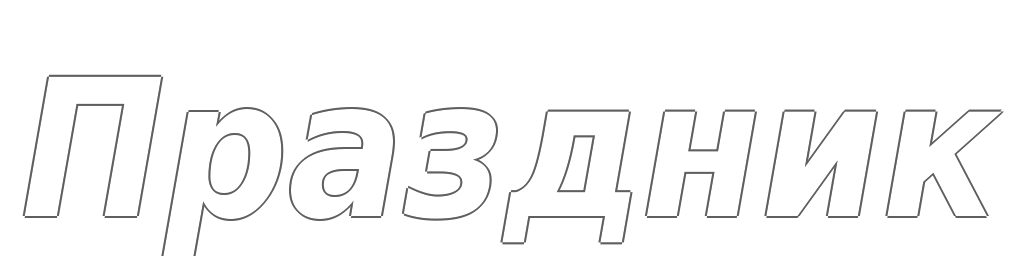

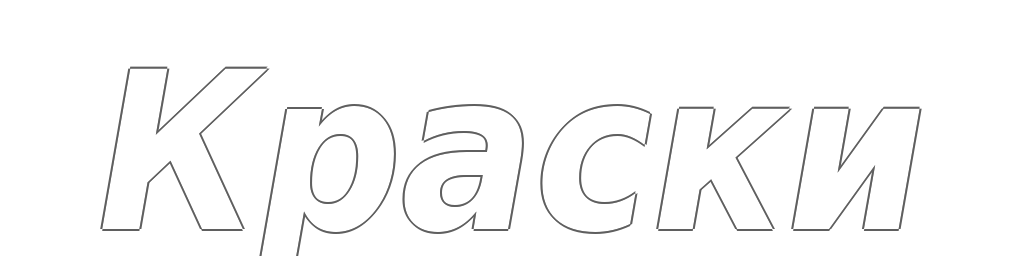

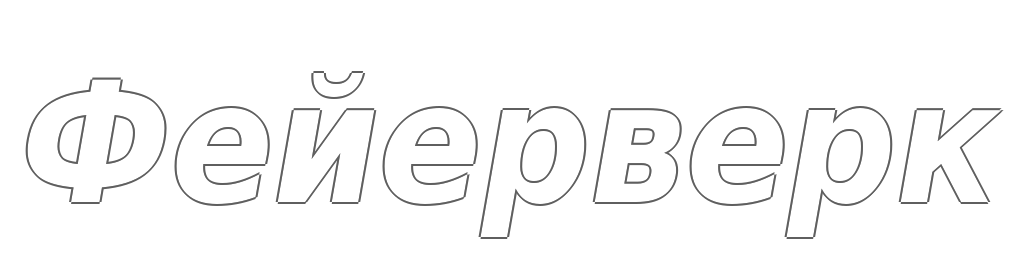

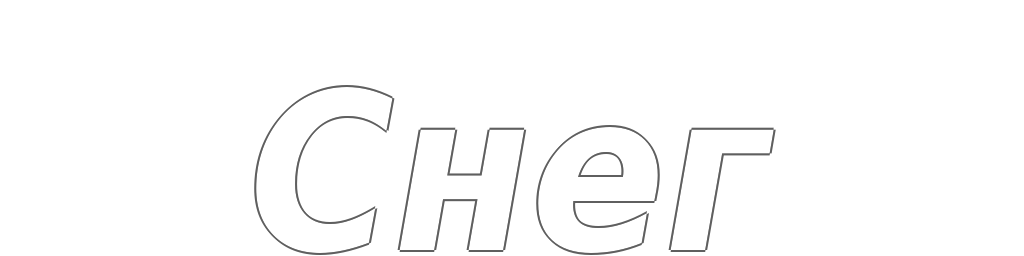

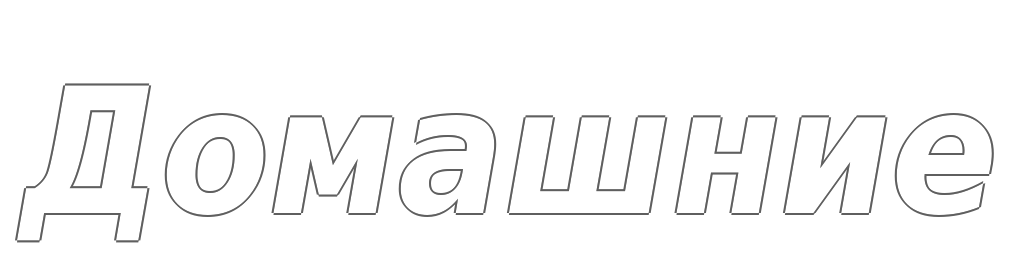

In [12]:
# only russian words generator for the prompts
import os, re, random, glob
from pathlib import Path
from typing import List
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = os.environ.get("SLOGAN_LLM", "Qwen/Qwen2.5-1.5B-Instruct")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if DEVICE == "cuda" else torch.float32

CANVAS_SIZE     = (1024, 256)
NUM_VARIANTS    = 5
FONTS_PER_TEXT  = 1
MAX_WORDS       = 3
MAX_CHARS       = 18
LANG            = "ru"
SEED            = 11
BG_MODE         = "transparent"

random.seed(SEED); torch.manual_seed(SEED)

def load_llm():
    tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME, dtype=DTYPE, device_map="auto", trust_remote_code=True
    )
    return tok, model

SYS = (
    "You output ultra-short keywords. "
    "Language: {lang}. One variant per line, no numbering. "
    "1 to {maxw} words. No punctuation, quotes, emoji, hashtags."
)

def gen_words(tok, model, topic: str, k: int) -> List[str]:
    sys_prompt = SYS.format(lang=LANG, maxw=MAX_WORDS)
    user = (
        f"Topic: {topic}\n"
        "Give 80 options. Use only the specified language. Keep them short."
    )
    if hasattr(tok, "apply_chat_template"):
        prompt = tok.apply_chat_template(
            [{"role":"system","content":sys_prompt},
             {"role":"user","content":user}],
            tokenize=False, add_generation_prompt=True
        )
    else:
        prompt = sys_prompt + "\n" + user + "\nAnswer:\n"

    out = model.generate(**tok(prompt, return_tensors="pt").to(model.device),
                         max_new_tokens=500, temperature=0.8, top_p=0.9,
                         do_sample=True, repetition_penalty=1.05,
                         eos_token_id=getattr(tok, "eos_token_id", None))
    txt = tok.decode(out[0], skip_special_tokens=True)

    lines = [re.sub(r"^[\-\*\d\.\)\s]+", "", l.strip()) for l in txt.split("\n")]
    rx_ru   = re.compile(r"^[А-Яа-яЁё0-9\s\-]+$")
    rx_trim = re.compile(r"\s+")
    topic_norm = rx_trim.sub(" ", topic.strip().lower())
    cand = []
    for l in lines[-250:]:
        l = l.replace("«","").replace("»","").replace('"',"").replace("'","").replace(":","").replace(",","").replace(".","")
        l = rx_trim.sub(" ", l).strip()
        if not l:                continue
        if not rx_ru.match(l):   continue
        if not (1 <= len(l.split()) <= MAX_WORDS):  continue
        if len(l) > MAX_CHARS:   continue
        if l.lower() == topic_norm: continue
        cand.append(l)

    seen, out = set(), []
    for c in cand:
        key = c.lower()
        if key not in seen:
            seen.add(key); out.append(c)
    if len(out) > k:
        out = out[:k]
    return out

SAFE_FAMILIES = ("DejaVuSans", "DejaVuSerif", "NotoSans", "NotoSerif", "FreeSans", "FreeSerif")

def collect_fonts() -> List[Path]:
    paths = []
    for d in ("/usr/share/fonts", "/usr/local/share/fonts"):
        for ext in ("*.ttf","*.otf","*.ttc"):
            paths += [Path(p) for p in glob.glob(os.path.join(d, "**", ext), recursive=True)]
    paths = [p for p in paths if any(fam in p.name for fam in SAFE_FAMILIES)]

    uniq, seen = [], set()
    for p in paths:
        if p.exists():
            k = (p.name, p.stat().st_size)
            if k not in seen:
                uniq.append(p); seen.add(k)
    uniq.sort(key=lambda p: next((i for i,f in enumerate(SAFE_FAMILIES) if f in p.name), 99))
    return uniq

def fit_font(font_path: Path, text: str, draw: ImageDraw.ImageDraw, w: int, h: int):
    lo, hi, best = 8, 220, None
    while lo <= hi:
        mid = (lo + hi)//2
        try:
            f = ImageFont.truetype(str(font_path), size=mid)
        except Exception:
            f = ImageFont.load_default()
        x0,y0,x1,y1 = draw.textbbox((0,0), text, font=f)
        if (x1-x0) <= w and (y1-y0) <= h:
            best = f; lo = mid + 1
        else:
            hi = mid - 1
    return best or ImageFont.load_default()

def render_text_line(text: str, font_path: Path, bg: str = "transparent"):
    W,H = CANVAS_SIZE
    mode = "RGBA" if bg == "transparent" else "RGB"
    bg_color = (0,0,0,0) if bg == "transparent" else (255,255,255)
    img = Image.new(mode, (W,H), bg_color)
    draw = ImageDraw.Draw(img)

    font = fit_font(font_path, text, draw, W-40, H-40)
    x0,y0,x1,y1 = draw.textbbox((0,0), text, font=font)
    x, y = (W - (x1-x0))//2, (H - (y1-y0))//2

    outline = (0,0,0,160) if mode=="RGBA" else (0,0,0)
    for dx,dy in [(-2,0),(2,0),(0,-2),(0,2)]:
        draw.text((x+dx,y+dy), text, font=font, fill=outline)
    fill = (255,255,255,255) if mode=="RGBA" else (20,20,20)
    draw.text((x,y), text, font=font, fill=fill)
    return img

def generate_and_display_words(topic: str, bg: str = BG_MODE):
    fonts = collect_fonts()
    if not fonts:
        raise SystemExit("No Cyrillic fonts found. Install DejaVu/Noto/FreeSans in the previous cell.")
    tok, model = load_llm()
    words = gen_words(tok, model, topic, NUM_VARIANTS)
    if not words:
        print("Nothing generated. Try another topic.")
        return
    base_font = next((p for p in fonts if "DejaVuSans" in p.name), fonts[0])
    for w in words:
        img = render_text_line(w, base_font, bg=bg)
        display(img)

generate_and_display_words("Новый год", bg="transparent")


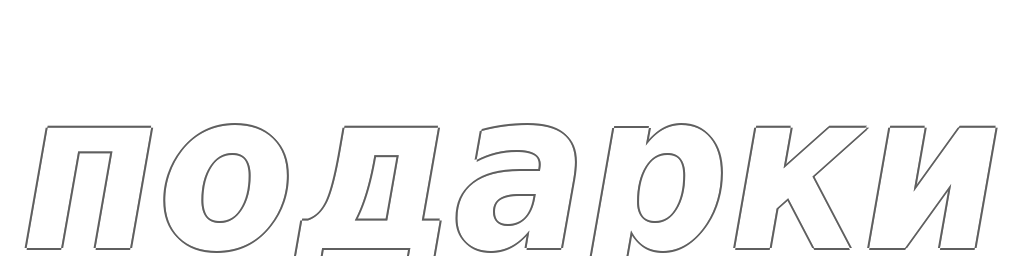

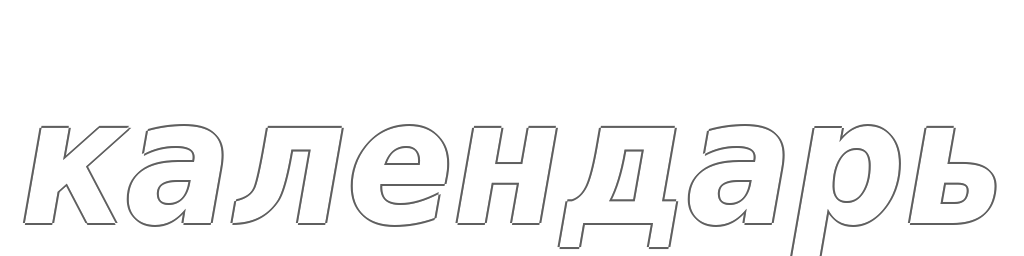

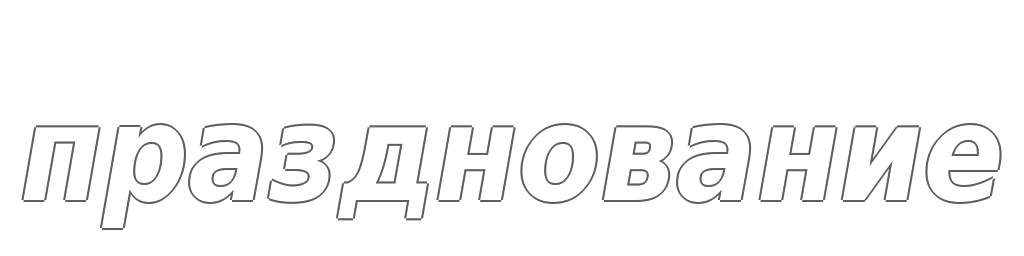

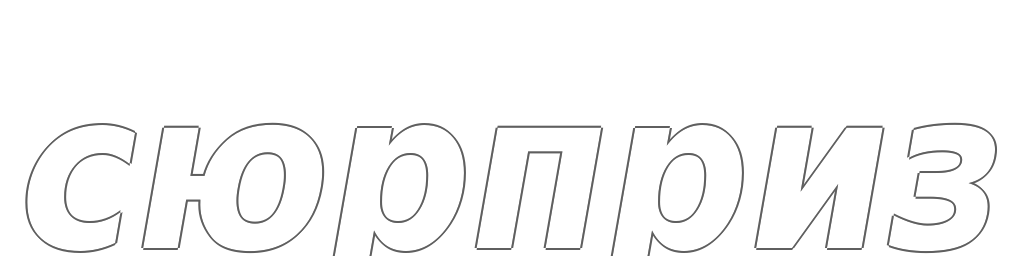

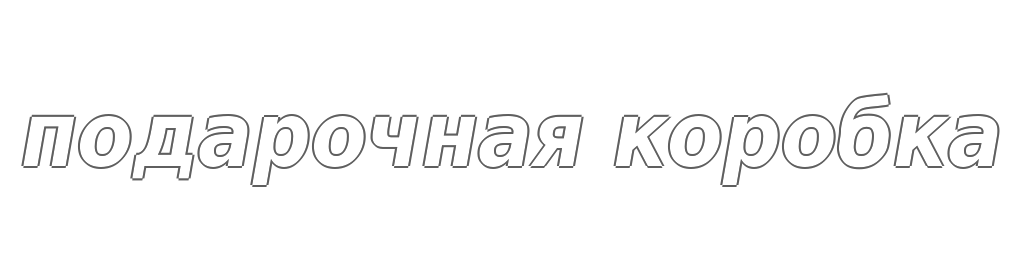

In [13]:
generate_and_display_words("день рождения", bg="transparent")

In [5]:
!pip -q install "transformers>=4.46" "accelerate>=0.33" torch pillow
!apt-get -y update -qq && apt-get -y install -qq fonts-dejavu fonts-dejavu-core fonts-dejavu-extra fonts-noto-core && fc-cache -f


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [6]:
!apt -qq update
!apt -qq install -y fonts-dejavu fonts-noto-core
!fc-cache -f


51 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
fonts-noto-core is already the newest version (20201225-1build1).
fonts-dejavu is already the newest version (2.37-2build1).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


Улучшили работу с той же моделью

`torch_dtype` is deprecated! Use `dtype` instead!


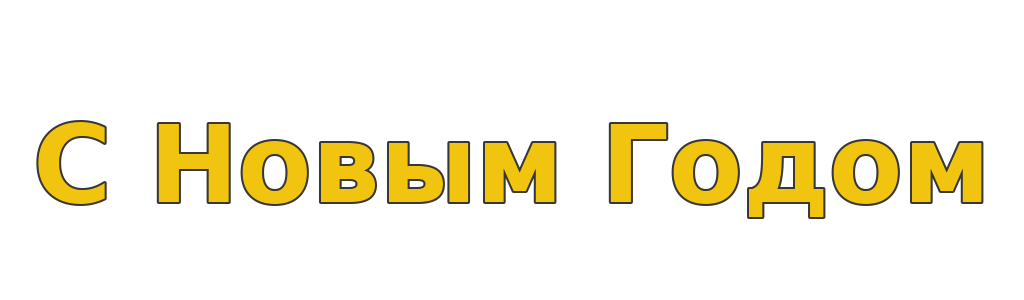

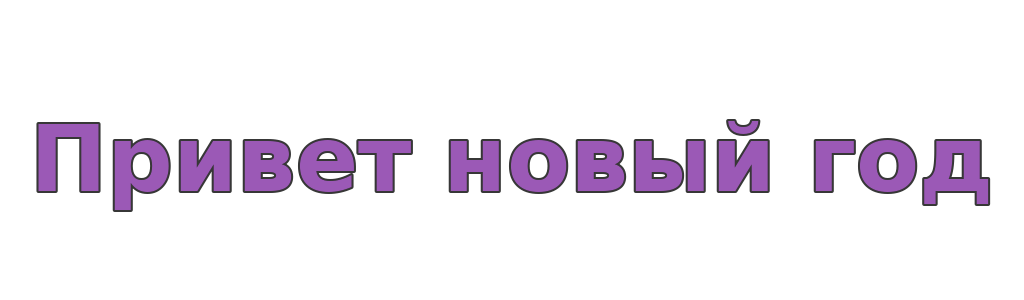

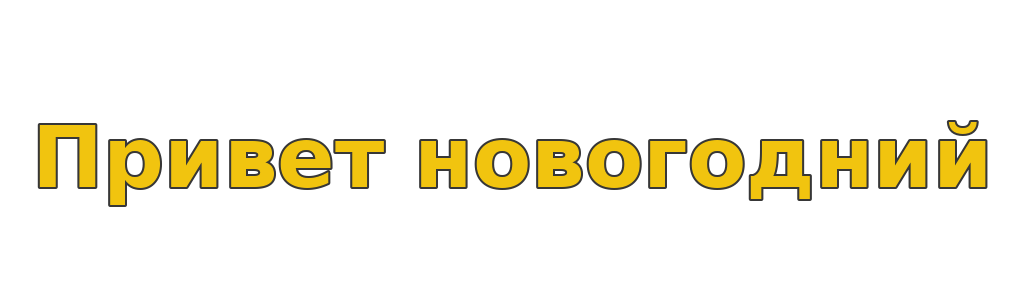

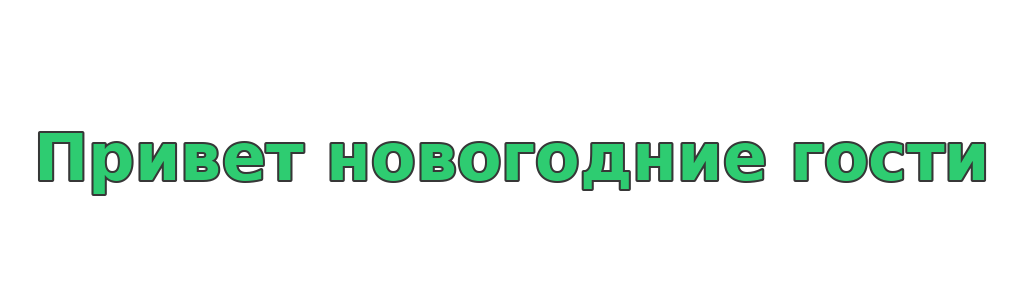

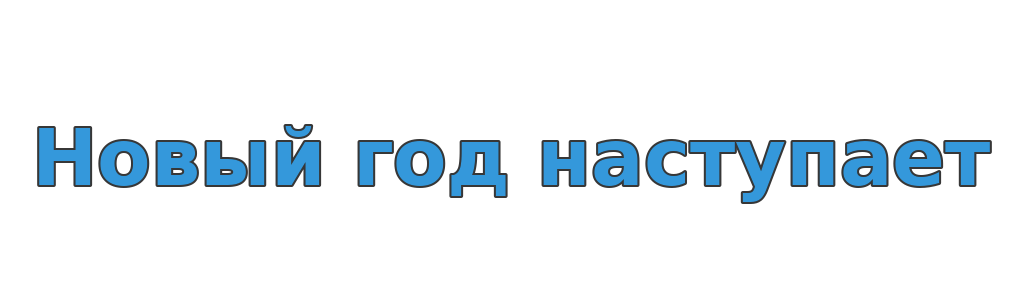

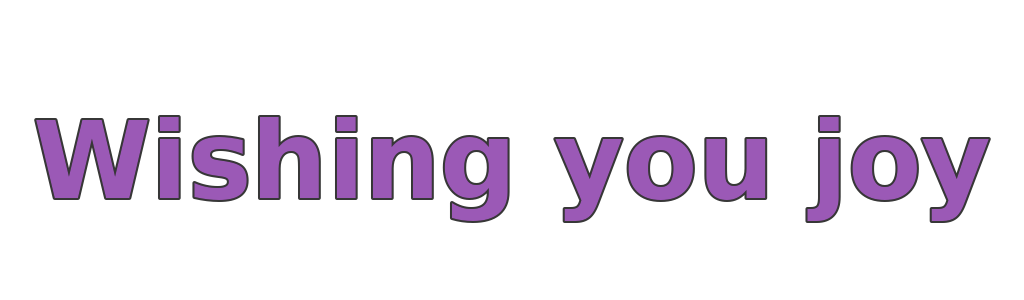

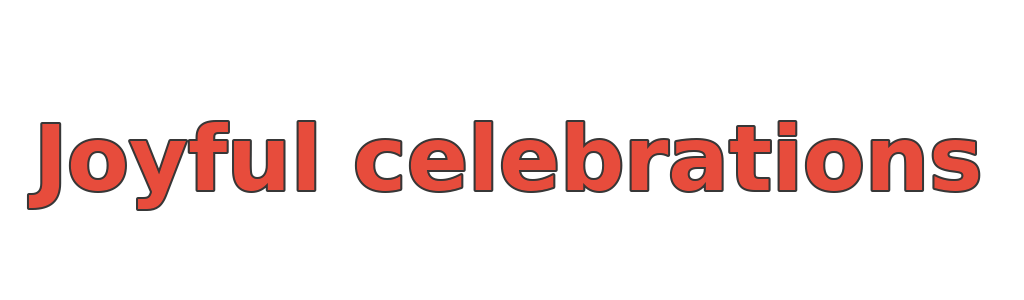

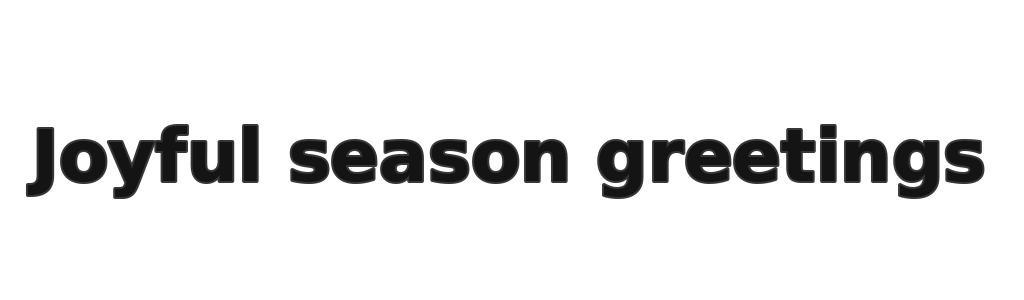

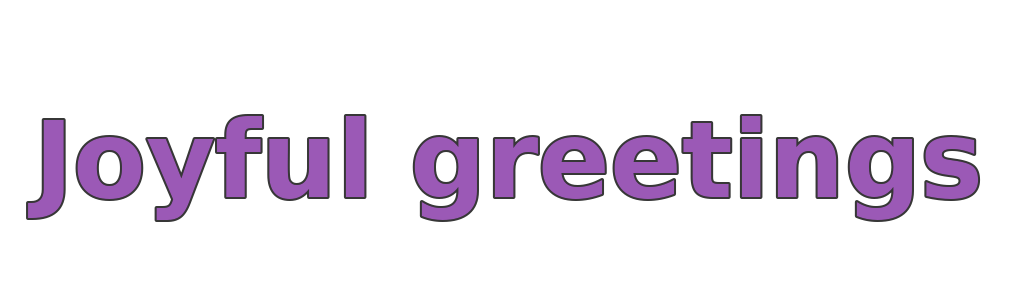

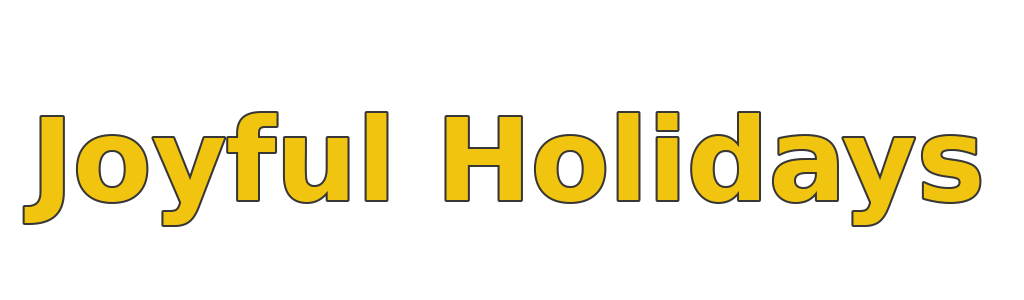

In [7]:
# the best way to generate text (en and ru)

# !pip -q install transformers accelerate torch pillow
# !apt -qq update && apt -qq install -y fonts-dejavu fonts-noto-core && fc-cache -f

import os, re, glob, random, unicodedata as ud
from pathlib import Path
from typing import List
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = os.environ.get("SLOGAN_LLM", "Qwen/Qwen2.5-1.5B-Instruct")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if DEVICE == "cuda" else torch.float32

W, H       = 1024, 300
K_OUT      = 5
SEED       = 23
BG_DEFAULT = "transparent"      # "transparent" | "white"
PALETTE    = [(231,76,60),(46,204,113),(52,152,219),(155,89,182),(241,196,15),(20,20,20)]

random.seed(SEED); torch.manual_seed(SEED)

SAFE_FAMILIES = ("DejaVuSans", "NotoSans")

def collect_fonts() -> list[Path]:
    roots = ("/usr/share/fonts", "/usr/local/share/fonts")
    keep = []
    for d in roots:
        keep += [Path(p) for p in glob.glob(os.path.join(d, "**", "DejaVuSans*.ttf"), recursive=True)]
        keep += [Path(p) for p in glob.glob(os.path.join(d, "**", "NotoSans*.ttf"),   recursive=True)]
    order = {"DejaVuSans.ttf":0, "DejaVuSans-Bold.ttf":1, "DejaVuSans-Oblique.ttf":2,
             "NotoSans-Regular.ttf":3, "NotoSans-Bold.ttf":4, "NotoSans-Italic.ttf":5}
    keep = [p for p in keep if p.exists()]
    keep.sort(key=lambda p: (order.get(p.name, 99), p.name))
    return keep


def font_supports_text(font_path: Path, text: str) -> bool:
    try:
        f = ImageFont.truetype(str(font_path), size=28)
    except Exception:
        return False
    for ch in text:
        if ch in " -":
            continue
        try:
            bbox = f.getbbox(ch)
        except Exception:
            try:
                w,h = f.getsize(ch); bbox = (0,0,w,h)
            except Exception:
                return False
        if not bbox or (bbox[2]-bbox[0]) <= 0 or (bbox[3]-bbox[1]) <= 0:
            return False
    return True

def load_llm():
    tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME, torch_dtype=DTYPE, device_map="auto", trust_remote_code=True
    )
    return tok, model

def detect_lang(text: str) -> str:
    return "ru" if re.search(r"[\u0400-\u04FF]", text) else "en"

def sanitize(text: str, lang: str) -> str:
    t = ud.normalize("NFKC", text)
    t = t.replace("\u00A0", " ").replace("\u2009", " ").replace("\u202F", " ")
    t = re.sub(r"[\"“”'«».,:;!?/\\()\[\]{}*_+=~^`|]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    allow = r"[^\u0400-\u04FF0-9\- ]" if lang == "ru" else r"[^A-Za-z0-9\- ]"
    t = re.sub(allow, "", t)
    t = re.sub(r"\s+", " ", t).strip()
    if re.search(r"\d{4}", t):
        t = re.sub(r"\d{4}", "", t).strip()
    return t

def gen_phrases(topic: str, lang: str, k: int) -> list[str]:
    tok, model = load_llm()
    RX = re.compile(r"^[\u0400-\u04FF0-9\- ]{1,40}$") if lang=="ru" else re.compile(r"^[A-Za-z0-9\- ]{1,40}$")

    examples = {
        "ru": "Примеры:\nС Новым годом\nС Рождеством\nЗимняя сказка\nТёплых праздников",
        "en": "Examples:\nMerry Christmas\nHappy New Year\nHoliday cheer\nWarm wishes",
    }
    script_rule = "Use only Cyrillic letters (А-Я, а-я)." if lang=="ru" else "Use only Latin letters (A–Z, a–z)."

    def ask_one() -> str:
        sys_prompt = (
            f"Generate ONE ultra-short greeting/tagline. Language: {lang}. "
            "1–4 words. No quotes, punctuation, emoji, hashtags. "
            + script_rule + "\n" + examples[lang]
        )
        user = f"Topic: {topic}\nReturn only the phrase on the first line."
        if hasattr(tok, "apply_chat_template"):
            prompt = tok.apply_chat_template(
                [{"role":"system","content":sys_prompt},
                 {"role":"user","content":user}],
                tokenize=False, add_generation_prompt=True
            )
        else:
            prompt = sys_prompt + "\n" + user + "\nAssistant:\n"

        enc = tok(prompt, return_tensors="pt"); enc = {k:v.to(model.device) for k,v in enc.items()}
        out = model.generate(**enc, max_new_tokens=48, temperature=0.6, top_p=0.85,
                             do_sample=True, repetition_penalty=1.08,
                             eos_token_id=getattr(tok,"eos_token_id",None))
        new = out[0, enc["input_ids"].shape[1]:]
        raw = tok.decode(new, skip_special_tokens=True)
        s = raw.splitlines()[0].strip() or re.split(r"[,\uFF0C;]+", raw)[0].strip()
        s = ud.normalize("NFKC", s)
        s = re.sub(r"[\"“”'«».,:;!?/\\()\[\]{}*_+=~^`|]", "", s)
        s = re.sub(r"\s+", " ", s).strip()
        s = re.sub(r"[^\u0400-\u04FF0-9\- ]","",s) if lang=="ru" else re.sub(r"[^A-Za-z0-9\- ]","",s)
        s = re.sub(r"\s+"," ",s).strip()
        return s

    res, seen, tries = [], set(), 0
    topic_norm = re.sub(r"\s+"," ", topic.lower()).strip()
    while len(res) < k and tries < k*10:
        tries += 1
        s = ask_one()
        if not s or not RX.match(s):
            continue
        if not (1 <= len(s.split()) <= 4):
            continue
        key = s.lower()
        if key == topic_norm or key in {"system","assistant","user","topic"}:
            continue
        if key in seen:
            continue
        seen.add(key); res.append(s)
    return res


def fit_font(font_path: Path, text: str, draw: ImageDraw.ImageDraw, w: int, h: int):
    lo, hi, best = 14, 260, None
    while lo <= hi:
        mid = (lo + hi)//2
        try:
            f = ImageFont.truetype(str(font_path), size=mid)
        except Exception:
            f = ImageFont.load_default()
        x0,y0,x1,y1 = draw.textbbox((0,0), text, font=f)
        if (x1-x0) <= w and (y1-y0) <= h:
            best = f; lo = mid + 1
        else:
            hi = mid - 1
    return best or ImageFont.load_default()

def render_phrase(text: str, font_path: Path, color=(20,20,20), bg="transparent"):
    fonts = collect_fonts()
    use = next((p for p in fonts if p.name.endswith("Bold.ttf")), fonts[0])

    mode = "RGBA" if bg=="transparent" else "RGB"
    img  = Image.new(mode, (W,H), (0,0,0,0) if mode=="RGBA" else (255,255,255))
    draw = ImageDraw.Draw(img)
    font = fit_font(use, text, draw, W-60, H-40)
    x0,y0,x1,y1 = draw.textbbox((0,0), text, font=font)
    x,y = (W-(x1-x0))//2, (H-(y1-y0))//2
    stroke = (0,0,0,200) if mode=="RGBA" else (0,0,0)
    draw.text((x,y), text, font=font, fill=color, stroke_width=2, stroke_fill=stroke)
    return img


# main function
def generate_and_display(topic: str, lang: str="auto", bg: str=BG_DEFAULT, k: int=K_OUT):
    fonts = collect_fonts()
    if not fonts:
        raise SystemExit("No fonts found. Install DejaVu/Noto.")
    lang = detect_lang(topic) if lang=="auto" else lang

    phrases = gen_phrases(topic, lang, k)
    if len(phrases) < k:
        need = k - len(phrases)
        extra = gen_phrases(topic + " variations", lang, need)
        for p in extra:
            if p.lower() not in {x.lower() for x in phrases}:
                phrases.append(p)
            if len(phrases) == k:
                break
    if not phrases:
        phrases = [sanitize(topic, lang)]

    base = next((p for p in fonts if "DejaVuSans" in p.name), fonts[0])
    alt  = next((p for p in fonts if "NotoSans"  in p.name), fonts[min(1, len(fonts)-1)])
    font_pool = [base, alt] + random.sample(fonts, k=min(3, len(fonts)))

    for t in phrases[:k]:
        img = render_phrase(t, random.choice(font_pool), color=random.choice(PALETTE), bg=bg)
        display(img)

generate_and_display("новый год", k=5)
generate_and_display("Merry Christmas", k=5)
